## Parameters
Golovin Kernel, B = 1500 / sec

**Collocation**
```
    ############################ SETUP ###################################
    casename = "examples/golovin16_IC2"

    # Numerical parameters
    FT = Float64
    tspan = (0.0, 2*3600.0)

    # basis setup 
    Nb = 16
    rmax  = 200.0
    rmin  = 2.0
    vmin = 4/3*pi*rmin^3
    vmax = 4/3*pi*rmax^3

    r_cutoff = 25
    v_cutoff = 4/3*pi*r_cutoff^3

    # Physical parameters: Kernel
    a = 0.0
    b = 1500 * 1e-12
    c = 0.0    
    r = v->(3/4/pi*v)^(1/3)
    area = v->4*pi*r(v)^2
    kernel_func = x -> a + b*(x[1]+x[2]) + c*(r(x[1])+r(x[2]))^2*abs(area(x[1])-area(x[2]))
    tracked_moments = [1.0]
    inject_rate = 0
    N     = 10             # initial droplet density: number per cm^3
    θ_r   = 15             # radius scale factor: µm
    θ_v   = 4/3*pi*θ_r^3
    k     = 3             # shape factor for particle size distribution 
    ρ_w   = 1.0e-12       # density of droplets: 1 g/µm^3

    # initial/injection distribution in volume
    n_v_init = v -> N/θ_v * exp(-v / θ_v)
    n_v_inject = v -> (r(v))^(k-1)/θ_r^k * exp(-r(v)/θ_r) / gamma(k)
```

**Bott**
```
Tmax, nbin, dt, scal, emin, rhow, B, k1, theta, N0 
[7200, 32, 1.0, 1, 7.091336e-10, 1e-09, 1.5e-12, 3, 1000, 100]
gmin = 1e-10
```

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma, Exponential
from PySDM.dynamics.collisions.collision_kernels import ConstantK, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**16
        self.n_part = 10 / si.cm**3
        self.r_scale = 15 * si.um
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 2*3600.0]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=Formulae().trivia.volume(self.r_scale))
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

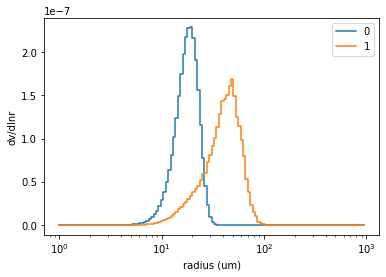

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


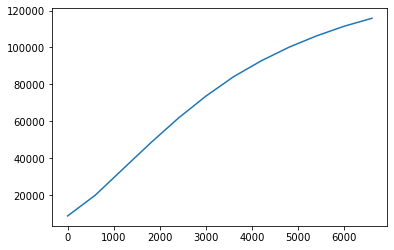

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# golovin_IC2
# Tmax, nbin, dt, scal, emin, rhow, B, k1, theta, N0 
# [7200, 32, 1.0, 1, 7.091336e-10, 1e-09, 1.5e-09, 1.0, 14137.166941154068, 10.0]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [2.40084895e-003, 9.60267324e-003, 3.84049132e-002, 1.53573426e-001,
 6.13924051e-001, 2.45274166e+000, 9.78737296e+000, 3.89614226e+001,
 1.54351960e+002, 6.05629257e+002, 2.33096767e+003, 8.63246975e+003,
 2.95987046e+004, 8.69937376e+004, 1.87870491e+005, 2.19048227e+005,
 7.44461241e+004, 2.14974427e+003, 4.48142597e-001, 4.86872324e-009,
 1.43665609e-025, 3.12729096e-059, 3.70458223e-127, 1.29963425e-263,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr18 = [1.60033940e-03, 6.40072331e-03, 2.55977434e-02, 1.02349790e-01,
 4.09069936e-01, 1.63364981e+00, 6.51362147e+00, 2.58876463e+01,
 1.02231439e+02, 3.98616982e+02, 1.51576028e+03, 5.48908826e+03,
 1.81273928e+04, 5.08405671e+04, 1.10184065e+05, 1.68036786e+05,
 1.58367700e+05, 7.99473865e+04, 1.75036100e+04, 1.30477620e+03,
 3.00981696e+01, 2.55362123e-01, 1.07960785e-03, 2.48250239e-06,
 7.45983570e-12, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr72 = [4.73997396e-04, 1.89573637e-03, 7.58086510e-03, 3.03068259e-02,
 1.21094369e-01, 4.83316232e-01, 1.92481070e+00, 7.63217645e+00,
 3.00011297e+01, 1.15923266e+02, 4.33151787e+02, 1.51843495e+03,
 4.74590634e+03, 1.23532366e+04, 2.55250672e+04, 4.33325114e+04,
 6.46654088e+04, 8.91887497e+04, 1.11858690e+05, 1.18031895e+05,
 9.03376416e+04, 4.04776569e+04, 8.49712546e+03, 7.33000153e+02,
 2.77219090e+01, 5.82695739e-01, 8.31226071e-03, 6.31260807e-05,
 9.72349205e-12, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900.,
 2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900.,
 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900.,
 4000., 4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900.,
 5000., 5100., 5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900.,
 6000., 6100., 6200., 6300., 6400., 6500., 6600., 6700., 6800., 6900.,
 7000., 7100., 7200.]
M0_bott = [9.9993864 , 9.7899723 , 9.58459213, 9.3832132 , 9.18578853, 8.99226436,
 8.80258318, 8.61668531, 8.43450973, 8.25599471, 8.08107816, 7.90969791,
 7.74179194, 7.57729847, 7.41615616, 7.25830411, 7.10368203, 6.95223021,
 6.80388963, 6.65860198, 6.51630967, 6.37695591, 6.24048466, 6.1068407 ,
 5.9759696 , 5.84781777, 5.72233244, 5.59946166, 5.47915432, 5.36136012,
 5.24602961, 5.13311414, 5.0225659 , 4.91433787, 4.80838387, 4.7046585 ,
 4.60311716, 4.50371604, 4.40641211, 4.3111631 , 4.21792753, 4.12666464,
 4.03733445, 3.94989767, 3.86431579, 3.78055096, 3.69856609, 3.61832474,
 3.53979118, 3.46293035, 3.38770786, 3.31408997, 3.24204359, 3.17153626,
 3.10253615, 3.03501205, 2.96893334, 2.90427002, 2.84099265, 2.77907238,
 2.71848093, 2.65919057, 2.60117411, 2.54440492, 2.48885687, 2.43450438,
 2.38132235, 2.32928621, 2.27837185, 2.22855567, 2.17981453, 2.13212577,
 2.08546717]
M1_bott = [141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246859, 141374.97246859, 141374.97246859,
 141374.97246859, 141374.97246858, 141374.97246858, 141374.97246858,
 141374.97246858, 141374.97246858, 141374.97246858, 141374.97246858,
 141374.97246858, 141374.97246858, 141374.97246858, 141374.97246858,
 141374.97246858]
M2_bott = [3.99886046e+09, 4.16083384e+09, 4.33072552e+09, 4.50858119e+09,
 4.69458775e+09, 4.88899739e+09, 5.09210421e+09, 5.30423416e+09,
 5.52574010e+09, 5.75699911e+09, 5.99841118e+09, 6.25039852e+09,
 6.51340528e+09, 6.78789768e+09, 7.07436428e+09, 7.37331649e+09,
 7.68528922e+09, 8.01084165e+09, 8.35055812e+09, 8.70504912e+09,
 9.07495233e+09, 9.46093372e+09, 9.86368878e+09, 1.02839437e+10,
 1.07224566e+10, 1.11800192e+10, 1.16574575e+10, 1.21556342e+10,
 1.26754495e+10, 1.32178428e+10, 1.37837949e+10, 1.43743292e+10,
 1.49905139e+10, 1.56334639e+10, 1.63043428e+10, 1.70043648e+10,
 1.77347975e+10, 1.84969636e+10, 1.92922438e+10, 2.01220790e+10,
 2.09879728e+10, 2.18914947e+10, 2.28342826e+10, 2.38180456e+10,
 2.48445676e+10, 2.59157102e+10, 2.70334164e+10, 2.81997138e+10,
 2.94167184e+10, 3.06866387e+10, 3.20117796e+10, 3.33945466e+10,
 3.48374502e+10, 3.63431103e+10, 3.79142615e+10, 3.95537574e+10,
 4.12645764e+10, 4.30498265e+10, 4.49127516e+10, 4.68567371e+10,
 4.88853158e+10, 5.10021751e+10, 5.32111630e+10, 5.55162956e+10,
 5.79217642e+10, 6.04319433e+10, 6.30513980e+10, 6.57848932e+10,
 6.86374013e+10, 7.16141121e+10, 7.47204420e+10, 7.79620435e+10,
 8.13448161e+10]
mprecip_bin = [   496.79993706,    971.24990236,   1548.85211361,   2228.08972178,
   3007.94008836,   3887.09622377,   4863.72190051,   5935.38353199,
   7099.05643094,   8351.16688353,   9687.65251638,  11104.03174835,
  12595.4769092 ,  14156.88756702,  15782.96174411,  17468.26343298,
  19207.28533612,  20994.50613303,  22824.44187093,  24691.69130501,
  26590.97519439,  28517.16970086,  30465.33414406,  32430.73344591,
  34408.85565157,  36395.42494917,  38386.41062809,  40378.03242018,
  42366.76266117,  44349.3256949 ,  46322.69492099,  48284.08786082,
  50230.95958785,  52160.99483747,  54072.09908071,  55962.38881499,
  57830.18129555,  59673.98390211,  61492.48330896,  63284.53460168,
  65049.15046083,  66785.49051252,  68492.85092721,  70170.65433156,
  71818.44008391,  73435.85495114,  75022.6442139 ,  76578.64321772,
  78103.76937987,  79598.01465486,  81061.43845634,  82494.16102838,
  83896.35725583,  85268.25090037,  86610.10924689,  87922.2381432 ,
  89204.97741499,  90458.6966373 ,  91683.79124327,  92880.67895115,
  94049.79649034,  95191.59660801,  96306.54533778,  97395.11951319,
  98457.8045087 ,  99495.09219222, 100507.47907362, 101495.46463469,
 102459.54982647, 103400.23572124, 104318.02230658, 105213.40741025,
 106086.88574503]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr72) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.011319209813756295, 5.007971833138832e-6, 2.167500100814402, 5.8877621048338495, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 0.0, 0.4857148732379415, 0.8533189970857736, 0.2666422432839989, 0.055213290316802534, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [9.705174773414926e-7, 0.12057762502197195, 0.09446231101681898, 0.275606184504158, 0.6998802079551418, 1.5890963874552382, 3.1355930770990152, 3.6885910551117798, 0.2395261260779029, 8.071150668242785e-8, 2.621979216442597e-8, 1.3915775033823228e-8, 1.1191120200057128e-8, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_final = [0.0, 0.028176945222011557, 0.021869466393752233, 0.06337670314986774, 0.15556910391228213, 0.33212075046301676, 0.5429841141903866, 0.5039389808664673, 0.3144327022969956, 0.1854354026940783, 0.0938475588064914, 0.018874152078491892, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# GAMMA CASE
# initial N, k, theta = 10.0, 1.0, 14137.166941154068, 
# final N, k, theta = 2.172266436663165, 0.12184759368279498, 534112.002542168, 
# def mom_f(x):
#     n = 2.172266436663165,
#     k = 0.12184759368279498
#     theta = 534112.002542168
#     return n*gamma.pdf(x, k, scale=theta)
# def mom_i(x):
#     n =10.0
#     k =1.0
#     theta = 14137.166941154068
#     return n*gamma.pdf(x, k, scale=theta)

# EXP CASE
# initial N, k, theta = 10.0, 1.0, 14137.166941154068, 
# final N, k, theta = 2.1722664374099234, 1.0, 65080.262244489466, 
def mom_f(x):
    n = 2.172266436663165,
    k = 1.0
    theta = 65080.262244489466
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =10.0
    k =1.0
    theta = 14137.166941154068
    return n*gamma.pdf(x, k, scale=theta)
    

In [12]:
col_8_times = [0.0, 0.5625342229586687, 3.9238591391273, 37.537108300813614, 254.64995247629315, 405.65971429362264, 843.9694476224413, 962.9332609205194, 1025.231083845792, 1640.8980495764063, 2091.2986313847823, 3111.8849073379997, 4094.8217742216902, 4720.529600912772, 6106.865340262588, 7200.0]
col_8_M_0 = [8.0609262822703, 8.060017104830616, 8.054587034184577, 8.00001237701376, 7.638412298791461, 7.381881276709316, 6.645101758747109, 6.452115747428789, 6.3528079693129715, 5.448066955420687, 4.882021049707437, 3.8716001025287126, 3.174381961666038, 2.7924337398009342, 2.0768538660640736, 1.6608894038804873]
col_8_M_1 = [141371.88186888164, 141403.61148339504, 141592.74805808303, 143437.93099413623, 153418.26000371628, 158533.64694014392, 166452.87388726382, 167171.193232909, 167352.69576787655, 163817.0654349798, 157468.93595796856, 139464.94237778956, 132235.1055492178, 140674.49189953582, 140242.1749508195, 130192.06443143016]
col_8_M_2 = [8.551692480400762e9, 8.5755500027668295e9, 8.717874766635633e9, 1.011942672701885e10, 1.824209689984059e10, 2.2986002153018658e10, 3.309543062933289e10, 3.504336564458451e10, 3.594657014230176e10, 4.14795417733133e10, 4.279322397060814e10, 4.1656186239242226e10, 7.293477050508247e10, 1.4016770783173004e11, 2.1906892822843192e11, 2.347814832574365e11]

col_16_times = [0.0, 0.4751739569109436, 3.3500762643430884, 13.416087151700218, 27.266506370718687, 45.04623372116155, 79.92841638679451, 132.35990982797568, 156.85225786948425, 401.7757382845698, 752.8700534077616, 965.4843876048305, 1302.628901021364, 1773.9628583596304, 2354.031731509489, 3097.4922222823507, 3713.6458949158864, 4706.328705178796, 5772.368630804333, 6748.707218968707, 7200.0]
col_16_M_0 = [9.814608425077534, 9.813637993833606, 9.807767702845121, 9.787221865431444, 9.758973225468564, 9.72274969554125, 9.651823841022331, 9.54560541556691, 9.496178662034719, 9.010220162917694, 8.348623051990689, 7.9813593132508025, 7.429950754751219, 6.718471006891627, 5.936608711744572, 5.083655649325069, 4.4737679669747905, 3.6494996206631742, 2.957597148976367, 2.4520069684104353, 2.253913296032395]
col_16_M_1 = [141371.06401646842, 141374.40998431024, 141394.783005143, 141464.3017474564, 141554.91760061646, 141662.3301859222, 141846.92283196346, 142060.3458438861, 142134.70651442243, 142084.26656654844, 140119.1912397899, 140435.80185254637, 141092.2888700847, 140978.77960091823, 138678.89426591925, 137009.6819641803, 136665.41795286842, 132281.23767090435, 127926.42120226956, 123530.20820647308, 120561.52429344971]
col_16_M_2 = [4.35033827315877e9, 4.351546098840639e9, 4.359594010466375e9, 4.391252088400904e9, 4.433309767363552e9, 4.475253256041782e9, 4.565031276310238e9, 4.698563660092014e9, 4.758122289415436e9, 5.279380348870023e9, 5.793928974082251e9, 6.455990296291445e9, 7.752633237596525e9, 9.471479129102354e9, 1.1231174541248388e10, 1.4998420941846521e10, 1.9475572166432564e10, 2.494984072069878e10, 3.4635755961955444e10, 4.475598671013188e10, 4.809115268227429e10]


In [13]:
# t_cloudy = [0.0, 0.05176767361782712, 0.5694444097960982, 5.7462117715788095, 45.13411780804701, 117.60879626994993, 204.86633527178512, 312.125793363782, 435.14691447532533, 574.4140378521422, 727.1991546348199, 892.3385369849802, 1067.8224546040003, 1252.2285351240039, 1444.049683749009, 1642.081561321653, 1845.22208837141, 2052.5763376703767, 2263.3688593448887, 2476.9681756753944, 2692.84731495823, 2910.5765426915477, 3129.8030124889424, 3350.239961080065, 3571.6540442041614, 3793.8562564034564, 4016.693596950009, 4240.042473843121, 4463.803134523018, 4687.895141913027, 4912.253749745311, 5136.826756128332, 5361.572203113172, 5586.4563293144965, 5811.451994518897, 6036.5373450774705, 6261.694843882426, 6486.910384614614, 6712.1726561525265, 6937.472534632678, 7162.802712828945, 7200.0]
# M0_cloudy = [10.0, 9.999890223365936, 9.998792523303118, 9.987822147765563, 9.904746281430995, 9.753686003378201, 9.574867044310599, 9.35954311017521, 9.118532895150686, 8.853176186795318, 8.570936946377902, 8.275985518089026, 7.973673706380039, 7.667883524486502, 7.362234750539598, 7.059465747928447, 6.761818768029545, 6.470936725212446, 6.188054510798865, 5.914017638260222, 5.649384563535815, 5.394476155295987, 5.149434371104563, 4.914261896438499, 4.6888579756545266, 4.473045087331889, 4.266590685557329, 4.069223799632629, 3.880647966715221, 3.700551082010362, 3.5286128142329334, 3.364510323541338, 3.207922314285336, 3.058532136586882, 2.916029957977731, 2.780114322605071, 2.650493138980635, 2.526884364611996, 2.4090163540456273, 2.2966280510038675, 2.189468953066861, 2.172266436663165]
# M1_cloudy = [141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067]
# M2_cloudy = [3.9971897824411893e9, 3.99727754349431e9, 3.998155260009484e9, 4.006943032172796e9, 4.0744412330584126e9, 4.201624412608389e9, 4.360027860198308e9, 4.562947486110048e9, 4.80733990599176e9, 5.09984003840479e9, 5.441243586946606e9, 5.836000555193513e9, 6.286918769736483e9, 6.7983536687199335e9, 7.374548672205952e9, 8.020678303196959e9, 8.742340460602102e9, 9.545978728189964e9, 1.0438702178378735e10, 1.1428508028863892e10, 1.2524271994340143e10, 1.3735871304030802e10, 1.5074250003489054e10, 1.6551531058731634e10, 1.8181119115249157e10, 1.997782557908095e10, 2.195800132071115e10, 2.413968601474992e10, 2.6542771831036232e10, 2.918918449866647e10, 3.2103083978126167e10, 3.53110830496959e10, 3.8842491889994576e10, 4.272958477708459e10, 4.7007895203946526e10, 5.171653963844089e10, 5.6898576342015305e10, 6.2601398079771576e10, 6.887716643478693e10, 7.578328709039932e10, 8.338293664128113e10, 8.470881077453453e10]

# EXP CASE
t_cloudy = [0.0, 0.05930493134719425, 0.6523542448191367, 6.582847379538561, 65.8877787267328, 196.52339326691936, 361.9814926264206, 562.3436075834226, 795.6128747753203, 1059.2440292372676, 1349.958563708345, 1664.4487347135605, 1999.4289187420843, 2351.888322600889, 2719.128505391127, 3098.814154453302, 3488.9511590439583, 3887.8839324314126, 4294.246867601467, 4706.9330056559875, 5125.059943762932, 5547.933287187901, 5975.017522359342, 6405.90969917544, 6840.317718226585, 7200.0]
M0_cloudy = [10.0, 9.999874240233549, 9.998616729551111, 9.986050316887908, 9.861251574430012, 9.591821734259529, 9.261112678744116, 8.87586602705375, 8.44749047900029, 7.9881919727349535, 7.510606708907519, 7.026061089558207, 6.544278698823659, 6.07298061777825, 5.617987416415122, 5.183384896256258, 4.771815394294184, 4.384739118968073, 4.022718107611554, 3.6856416227823114, 3.3729160706254335, 3.083619925451269, 2.81662057992441, 2.5706630735183866, 2.3444348967046285, 2.1722664374099225]
M1_cloudy = [141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067, 141371.66941154067]
M2_cloudy = [3.997189782441189e9, 3.9972400516387234e9, 3.9977427783859487e9, 4.0027735246650434e9, 4.053430492338118e9, 4.1672894817928605e9, 4.316101014098925e9, 4.503436363570275e9, 4.731807383953669e9, 5.003872961596656e9, 5.322059771417073e9, 5.689090560828768e9, 6.107914968779811e9, 6.581924155561569e9, 7.114985289503948e9, 7.711543445921201e9, 8.376664753671652e9, 9.116140490889473e9, 9.936539612054691e9, 1.084530236942486e10, 1.1850842709228746e10, 1.2962653890804083e10, 1.4191438530739067e10, 1.5549255846159409e10, 1.7049694099246246e10, 1.8401010638488678e10]


## Plotting

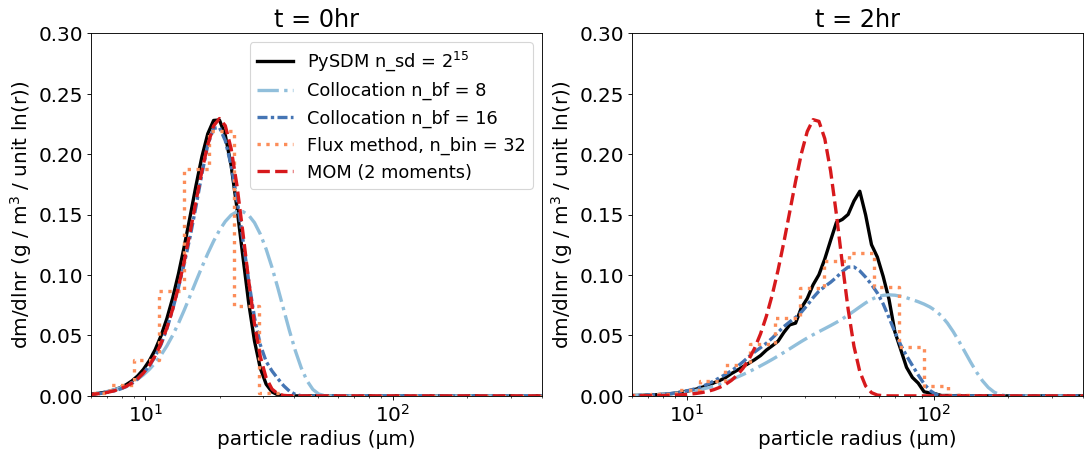

In [14]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],label='Flux method, n_bin = 32', linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],label="MOM (2 moments)",linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (2 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([6.0, 400.0])
ax[1].set_xlim([6.0, 400.0])
ax[0].set_ylim([0.0, 0.3])
ax[1].set_ylim([0.0, 0.3])
ax[0].legend(fontsize=16)

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 2hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.savefig("m(v)_golovin_IC2.pdf", transparent=True)

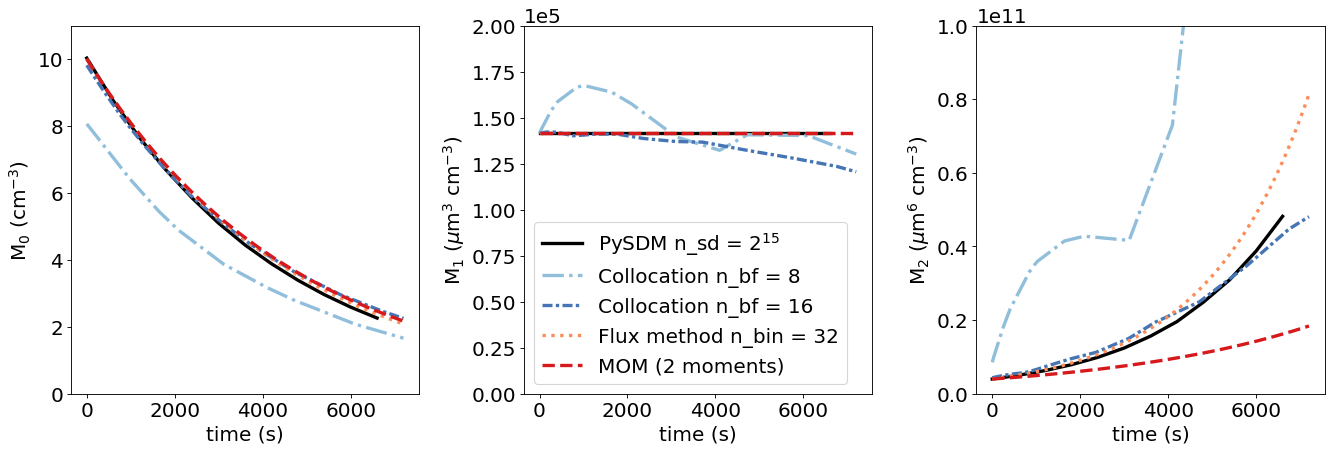

In [15]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (2 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 11])
ax[1].set_ylim([0, 2e5])
ax[2].set_ylim([0, 1e11])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_golovin_IC2.pdf", transparent=True)


In [16]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

In [17]:
t_precip_16 = [0.0, 72.72727272727273, 145.45454545454547, 218.1818181818182, 290.90909090909093, 363.6363636363636, 436.3636363636364, 509.09090909090907, 581.8181818181819, 654.5454545454545, 727.2727272727273, 800.0, 872.7272727272727, 945.4545454545455, 1018.1818181818181, 1090.909090909091, 1163.6363636363637, 1236.3636363636363, 1309.090909090909, 1381.8181818181818, 1454.5454545454545, 1527.2727272727273, 1600.0, 1672.7272727272727, 1745.4545454545455, 1818.1818181818182, 1890.909090909091, 1963.6363636363637, 2036.3636363636363, 2109.090909090909, 2181.818181818182, 2254.5454545454545, 2327.2727272727275, 2400.0, 2472.7272727272725, 2545.4545454545455, 2618.181818181818, 2690.909090909091, 2763.6363636363635, 2836.3636363636365, 2909.090909090909, 2981.818181818182, 3054.5454545454545, 3127.2727272727275, 3200.0, 3272.7272727272725, 3345.4545454545455, 3418.181818181818, 3490.909090909091, 3563.6363636363635, 3636.3636363636365, 3709.090909090909, 3781.818181818182, 3854.5454545454545, 3927.2727272727275, 4000.0, 4072.7272727272725, 4145.454545454545, 4218.181818181818, 4290.909090909091, 4363.636363636364, 4436.363636363636, 4509.090909090909, 4581.818181818182, 4654.545454545455, 4727.272727272727, 4800.0, 4872.727272727273, 4945.454545454545, 5018.181818181818, 5090.909090909091, 5163.636363636364, 5236.363636363636, 5309.090909090909, 5381.818181818182, 5454.545454545455, 5527.272727272727, 5600.0, 5672.727272727273, 5745.454545454545, 5818.181818181818, 5890.909090909091, 5963.636363636364, 6036.363636363636, 6109.090909090909, 6181.818181818182, 6254.545454545455, 6327.272727272727, 6400.0, 6472.727272727273, 6545.454545454545, 6618.181818181818, 6690.909090909091, 6763.636363636364, 6836.363636363636, 6909.090909090909, 6981.818181818182, 7054.545454545455, 7127.272727272727, 7200.0]
m_precip_16 = [11547.595626181239, 13364.86467146079, 15062.86955931067, 16646.986006173345, 18122.779507557916, 19495.683663718064, 20771.39260754614, 21955.59929242086, 23050.58468080915, 24061.382734673964, 24994.075741644938, 26313.796807578743, 28024.32605679473, 29743.255876205498, 31461.951462229845, 33172.55770909347, 34867.86663376196, 36541.352028924295, 38187.160073798754, 39800.0670311947, 41375.51455488251, 42909.5207418217, 44398.625217650726, 45839.88913668689, 47230.89518192648, 48569.71186474261, 49854.79421232926, 51085.0783251584, 52259.80375167341, 53382.1075486121, 54452.39884675642, 55466.37186280238, 56424.28015655335, 57325.59809386167, 58169.01996231967, 58958.93887823183, 59699.69049520826, 60661.97853327289, 61931.12101795019, 63264.12348510088, 64571.24074209761, 65849.16501725485, 67095.17364100728, 68307.12281258099, 69483.27159888836, 70622.06072752914, 71722.10478605595, 72782.19066341227, 73801.27754993245, 74778.49693734173, 75713.15261875631, 76604.72068868314, 77452.76854486138, 78257.06476399279, 79017.62634944441, 79734.56387402152, 80408.08103930156, 81038.4746756338, 81626.1347421397, 82171.54432671252, 82675.27964601768, 83138.01004549253, 83560.49799934638, 83943.5991105607, 84288.26211088881, 84595.68456050975, 84869.0635060547, 85108.68212631231, 85313.87673206384, 85484.1714355784, 85623.61618193993, 86011.85724167284, 86552.08808051626, 87131.20007642717, 87684.87327802356, 88211.42263549409, 88709.68331427866, 89179.01069506856, 89619.28037380578, 90030.8881616838, 90414.3799456154, 90769.16038666657, 91095.31643140386, 91393.07437343162, 91662.70085609079, 91904.50287245953, 92118.82776535297, 92306.06322732301, 92466.63730065868, 92601.01837738582, 92709.7151992674, 92793.2768578032, 92852.29279423002, 92887.39129548399, 92899.18131750292, 92888.28707753318, 92855.36030050807, 92801.06206419786, 92726.06279920979, 92631.04228898809]
t_precip_8 = [0.0, 72.72727272727273, 145.45454545454547, 218.1818181818182, 290.90909090909093, 363.6363636363636, 436.3636363636364, 509.09090909090907, 581.8181818181819, 654.5454545454545, 727.2727272727273, 800.0, 872.7272727272727, 945.4545454545455, 1018.1818181818181, 1090.909090909091, 1163.6363636363637, 1236.3636363636363, 1309.090909090909, 1381.8181818181818, 1454.5454545454545, 1527.2727272727273, 1600.0, 1672.7272727272727, 1745.4545454545455, 1818.1818181818182, 1890.909090909091, 1963.6363636363637, 2036.3636363636363, 2109.090909090909, 2181.818181818182, 2254.5454545454545, 2327.2727272727275, 2400.0, 2472.7272727272725, 2545.4545454545455, 2618.181818181818, 2690.909090909091, 2763.6363636363635, 2836.3636363636365, 2909.090909090909, 2981.818181818182, 3054.5454545454545, 3127.2727272727275, 3200.0, 3272.7272727272725, 3345.4545454545455, 3418.181818181818, 3490.909090909091, 3563.6363636363635, 3636.3636363636365, 3709.090909090909, 3781.818181818182, 3854.5454545454545, 3927.2727272727275, 4000.0, 4072.7272727272725, 4145.454545454545, 4218.181818181818, 4290.909090909091, 4363.636363636364, 4436.363636363636, 4509.090909090909, 4581.818181818182, 4654.545454545455, 4727.272727272727, 4800.0, 4872.727272727273, 4945.454545454545, 5018.181818181818, 5090.909090909091, 5163.636363636364, 5236.363636363636, 5309.090909090909, 5381.818181818182, 5454.545454545455, 5527.272727272727, 5600.0, 5672.727272727273, 5745.454545454545, 5818.181818181818, 5890.909090909091, 5963.636363636364, 6036.363636363636, 6109.090909090909, 6181.818181818182, 6254.545454545455, 6327.272727272727, 6400.0, 6472.727272727273, 6545.454545454545, 6618.181818181818, 6690.909090909091, 6763.636363636364, 6836.363636363636, 6909.090909090909, 6981.818181818182, 7054.545454545455, 7127.272727272727, 7200.0]
m_precip_8 = [46094.25145425666, 51498.75334897222, 56540.96559284577, 61222.62883201815, 65565.69223684625, 69577.90023427835, 73272.21592050442, 76662.29911111933, 79762.47435865375, 82587.14134358775, 85150.69802283938, 87467.54062976464, 89626.001534369, 91417.77678104874, 93078.92283957769, 94548.6998795072, 95839.58163426004, 96963.65831604852, 97932.4849824532, 98757.08195530165, 99447.93482066879, 100014.99442887651, 100467.39765552181, 100813.98942398274, 101063.34098344203, 101223.13465263731, 101300.59238445228, 101302.47708773463, 101235.09262729612, 101104.29878962346, 100915.76603531968, 100674.4500022044, 100384.8846642721, 100051.35633419351, 99677.90366331497, 99268.31764165897, 98826.141597924, 98354.67119948406, 97856.95445238952, 97335.79170136651, 96793.73562981698, 96233.091259819, 95655.91595212638, 95063.85305007511, 94454.7215192357, 93831.58096093367, 93199.16349594355, 92561.0009891051, 91919.42504932325, 91275.56702956822, 90629.35802687537, 89979.52888234545, 89323.61018114434, 89354.81002505045, 91549.6610354177, 93668.46253209916, 95692.0470059049, 97606.74850864548, 99423.93510207994, 101144.71947679739, 102769.34527447689, 104298.35526697623, 105732.59135633125, 107073.1945747564, 108321.60508464467, 109479.55702506188, 110548.46122442285, 111530.36731972327, 112427.88738505874, 113243.63166939648, 113980.20859657617, 114640.22476530941, 115226.28494917983, 115740.99209664314, 116186.94733102701, 116566.74995053158, 116882.99742822845, 117138.28541206189, 117335.20772484774, 117476.35636427425, 117564.32150290176, 117601.69148816209, 117591.0528423601, 117534.99026267181, 117436.08643158001, 117296.65283318149, 117118.79127770333, 116904.67732787054, 116656.41324317685, 116376.02797988389, 116065.47719102222, 115726.64322639047, 115361.33513255573, 114971.28865285357, 114558.16622738788, 114123.55699303115, 113668.97678342399, 113195.86812897559, 112705.60025686353, 112199.4690910336]

In [18]:
# GAMMA CASE
# t_precip_mom = [0.0, 72.72727272727273, 145.45454545454547, 218.1818181818182, 290.90909090909093, 363.6363636363636, 436.3636363636364, 509.09090909090907, 581.8181818181819, 654.5454545454545, 727.2727272727273, 800.0, 872.7272727272727, 945.4545454545455, 1018.1818181818181, 1090.909090909091, 1163.6363636363637, 1236.3636363636363, 1309.090909090909, 1381.8181818181818, 1454.5454545454545, 1527.2727272727273, 1600.0, 1672.7272727272727, 1745.4545454545455, 1818.1818181818182, 1890.909090909091, 1963.6363636363637, 2036.3636363636363, 2109.090909090909, 2181.818181818182, 2254.5454545454545, 2327.2727272727275, 2400.0, 2472.7272727272725, 2545.4545454545455, 2618.181818181818, 2690.909090909091, 2763.6363636363635, 2836.3636363636365, 2909.090909090909, 2981.818181818182, 3054.5454545454545, 3127.2727272727275, 3200.0, 3272.7272727272725, 3345.4545454545455, 3418.181818181818, 3490.909090909091, 3563.6363636363635, 3636.3636363636365, 3709.090909090909, 3781.818181818182, 3854.5454545454545, 3927.2727272727275, 4000.0, 4072.7272727272725, 4145.454545454545, 4218.181818181818, 4290.909090909091, 4363.636363636364, 4436.363636363636, 4509.090909090909, 4581.818181818182, 4654.545454545455, 4727.272727272727, 4800.0, 4872.727272727273, 4945.454545454545, 5018.181818181818, 5090.909090909091, 5163.636363636364, 5236.363636363636, 5309.090909090909, 5381.818181818182, 5454.545454545455, 5527.272727272727, 5600.0, 5672.727272727273, 5745.454545454545, 5818.181818181818, 5890.909090909091, 5963.636363636364, 6036.363636363636, 6109.090909090909, 6181.818181818182, 6254.545454545455, 6327.272727272727, 6400.0, 6472.727272727273, 6545.454545454545, 6618.181818181818, 6690.909090909091, 6763.636363636364, 6836.363636363636, 6909.090909090909, 6981.818181818182, 7054.545454545455, 7127.272727272727, 7200.0]
# m_precip_mom = [7766.3973926793315, 8858.974008069184, 10031.875856019256, 11283.191878963584, 12610.462717260349, 14010.742571804427, 15480.663225141849, 17016.49857266865, 18614.228130994914, 20269.598458569366, 21978.181467848557, 23735.429048940892, 25536.72335562414, 27377.422745532585, 29252.902711603263, 31158.59255426266, 33090.00687521534, 35042.7730535358, 37012.654240881726, 38995.56819238368, 40987.60291642918, 42985.02822956125, 44984.30467828512, 46982.089787835306, 48975.24123286485, 50960.81859517301, 52936.08281890335, 54898.49386323361, 56845.707653284735, 58775.57118876995, 60686.11689441244, 62575.55670379046, 64442.27476853044, 66284.82011693703, 68101.89934893645, 69892.36833647877, 71655.22430992856, 73389.59819517868, 75094.74622502395, 76770.04218515384, 78414.97004999808, 80029.11606741611, 81612.161601059, 83163.87643890205, 84684.11165903979, 86172.79329093051, 87629.91647346065, 89055.5392371898, 90449.7770602834, 91812.79792410755, 93144.8170364462, 94446.0922645826, 95716.9200575159, 96957.63106802478, 98168.58639181801, 99350.17428108022, 100502.80658698326, 101626.91570824248, 102722.95199925799, 103791.38093838439, 104832.68068200618, 105847.34006388344, 106835.8563906442, 107798.73350139218, 108736.48025740182, 109649.60886967895, 110538.63337396565, 111404.06851792167, 112246.42853271666, 113066.22594566527, 113863.97078295884, 114640.16970592189, 115395.32509622254, 116129.93450443292, 116844.49008048614, 117539.47787823279, 118215.3774925184, 118872.66172180565, 119511.79604917791, 120133.23842253421, 120737.43909496696, 121324.84024792742, 121895.87588014962, 122450.971778039, 122990.54525373138, 123515.00511814184, 124024.75173849618, 124520.17687435972, 125001.66370891787, 125469.58696495621, 125924.31282479626, 126366.19899492449, 126795.59486350977, 127212.84148874956, 127618.2716805588, 128012.21018477678, 128394.97372708416, 128766.8711012116, 129128.20336732105, 129479.26393516819]

# EXP CASE
t_precip_mom = [0.0, 72.72727272727273, 145.45454545454547, 218.1818181818182, 290.90909090909093, 363.6363636363636, 436.3636363636364, 509.09090909090907, 581.8181818181819, 654.5454545454545, 727.2727272727273, 800.0, 872.7272727272727, 945.4545454545455, 1018.1818181818181, 1090.909090909091, 1163.6363636363637, 1236.3636363636363, 1309.090909090909, 1381.8181818181818, 1454.5454545454545, 1527.2727272727273, 1600.0, 1672.7272727272727, 1745.4545454545455, 1818.1818181818182, 1890.909090909091, 1963.6363636363637, 2036.3636363636363, 2109.090909090909, 2181.818181818182, 2254.5454545454545, 2327.2727272727275, 2400.0, 2472.7272727272725, 2545.4545454545455, 2618.181818181818, 2690.909090909091, 2763.6363636363635, 2836.3636363636365, 2909.090909090909, 2981.818181818182, 3054.5454545454545, 3127.2727272727275, 3200.0, 3272.7272727272725, 3345.4545454545455, 3418.181818181818, 3490.909090909091, 3563.6363636363635, 3636.3636363636365, 3709.090909090909, 3781.818181818182, 3854.5454545454545, 3927.2727272727275, 4000.0, 4072.7272727272725, 4145.454545454545, 4218.181818181818, 4290.909090909091, 4363.636363636364, 4436.363636363636, 4509.090909090909, 4581.818181818182, 4654.545454545455, 4727.272727272727, 4800.0, 4872.727272727273, 4945.454545454545, 5018.181818181818, 5090.909090909091, 5163.636363636364, 5236.363636363636, 5309.090909090909, 5381.818181818182, 5454.545454545455, 5527.272727272727, 5600.0, 5672.727272727273, 5745.454545454545, 5818.181818181818, 5890.909090909091, 5963.636363636364, 6036.363636363636, 6109.090909090909, 6181.818181818182, 6254.545454545455, 6327.272727272727, 6400.0, 6472.727272727273, 6545.454545454545, 6618.181818181818, 6690.909090909091, 6763.636363636364, 6836.363636363636, 6909.090909090909, 6981.818181818182, 7054.545454545455, 7127.272727272727, 7200.0]
m_precip_mom = [7766.397392679327, 8231.70400436205, 8715.73879938374, 9218.714151199458, 9740.81780853035, 10282.21215884702, 10843.03357277018, 11423.391825975556, 12023.3696184707, 12643.022162824378, 13282.376866412706, 13941.433114685799, 14620.162115734, 15318.506837030885, 16036.38205907042, 16773.674475829983, 17530.242883449802, 18305.918456249594, 19100.505134837153, 19913.780029457117, 20745.493922959213, 21595.37183706106, 22463.11372017696, 23348.395118080614, 24250.86793210725, 25170.16121486607, 26105.882093301614, 27057.61668042469, 28024.930991597423, 29007.3719549149, 30004.4684168161, 31015.73227883435, 32040.65954477288, 33078.73139182634, 34129.41530968721, 35192.166217281665, 36266.427689480865, 37351.633057498795, 38447.206519796164, 39552.56431534259, 40667.115827608875, 41790.26481842946, 42921.41049941883, 44059.948579953416, 45205.272393279396, 46356.77388800373, 47513.844789746814, 48675.87758829462, 49842.266455503464, 51012.40822068591, 52185.70324804347, 53361.55638803447, 54539.37787987805, 55718.58410443632, 56898.59832090233, 58078.85146061298, 59258.782754003325, 60437.840538553704, 61615.48284402506, 62791.17791163735, 63964.40475866966, 65134.65365948568, 66301.42664600044, 67464.2380172283, 68622.61466639416, 69776.09637371276, 70924.2361878886, 72066.60060425846, 73202.76994453096, 74332.33856578082, 75454.91497117258, 76570.12191223582, 77677.59656000957, 78776.99049066234, 79867.96988648576, 80950.21552082938, 82023.42268934059, 83087.30116250904, 84141.57516305495, 85185.98322768426, 86220.2782365794, 87244.22723877273, 88257.61124796617, 89260.22508552085, 90251.87720477865, 91232.38947468859, 92201.59707461676, 93159.34821500145, 94105.50384226444, 95039.93740805805, 95962.53459184992, 96873.1930365095, 97771.8221552247, 98658.3427929099, 99532.68688045556, 100394.79714327154, 101244.62681788146, 102082.13934974873, 102907.30811113394, 103720.11603918983]


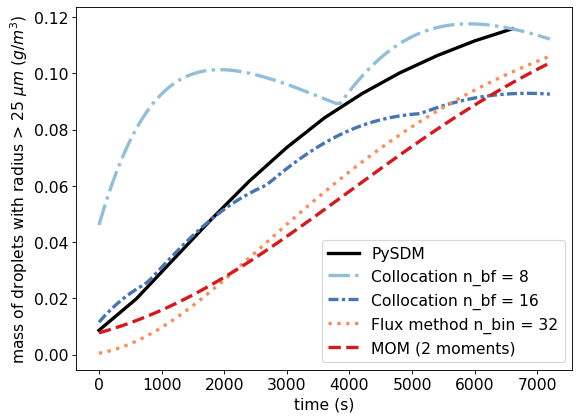

In [19]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (2 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.savefig('m_precip_golovin_IC2.pdf', transparent=True)

## Error Computation

In [21]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("golovin_IC2_errors.pkl", "wb" ))

0.6302005372935078 0.2795561106597422 0.9243035907925171 0.3103908834404011
